Neste projeto analisaremos uma base de dados de aplicações de crédito. O objetivo é realizar uma clusterização para classificar perfis de diferentes clientes. Este agrupamento de clientes pode ser usado para definir estratégias diferentes para cada grupo, sejam ações de marketing, métricas diferentes para determinar o score para empréstimos e assim por diante.

* Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans

### Entendimento dos dados

* Carregando os dados

Os dados foram obtidos no site Kaggle, uma plataforma voltada a ciência de dados. 

link: https://www.kaggle.com/datasets/kamaumunyori/german-bank-credit-data

In [2]:
df = pd.read_csv('german_credit_data.csv')
df.drop(columns=['Unnamed: 0', 'Purpose'], inplace=True)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
0,67,male,2,own,NaN,little,1169,6
1,22,female,2,own,little,moderate,5951,48
2,49,male,1,own,little,NaN,2096,12
3,45,male,2,free,little,little,7882,42
4,53,male,2,free,little,little,4870,24


In [3]:
# Definindo uma função para criar os metadados de um dataframe

def metadados(df):
    ''' Cria uma tabela com informações do dataframe'''

    meta = pd.DataFrame({'dtypes': df.dtypes})
    meta['nunique'] = df.nunique()
    meta['missing'] = df.isnull().sum()
    
    return meta

metadados(df)

,dtypes,nunique,missing
Age,int64,53,0
Sex,object,2,0
Job,int64,4,0
Housing,object,3,0
Saving accounts,object,4,183
Checking account,object,3,394
Credit amount,int64,921,0
Duration,int64,33,0


In [4]:
print(f'Número de linhas: {df.shape[0]}\nNúmero de colunas: {df.shape[1]}')

Número de linhas: 1000
Número de colunas: 8


In [5]:
# Visualizando a separação de dados em categóricos e numéricos:

df_categorica = df.select_dtypes('object')
df_numerica = df.select_dtypes(exclude='object')

list_cat = list(df_categorica.columns)
list_num = list(df_numerica.columns)

print(f'Número de colunas com variáveis categóricas: {df_categorica.shape[1]}.\n  Lista:\n {list_cat}')
print('\n\n')
print(f'Número de colunas com variáveis numericas: {df_numerica.shape[1]}.\n  Lista:\n {list_num}')

Número de colunas com variáveis categóricas: 4.
  Lista:
 ['Sex', 'Housing', 'Saving accounts', 'Checking account']



Número de colunas com variáveis numericas: 4.
  Lista:
 ['Age', 'Job', 'Credit amount', 'Duration']


In [6]:
# Estatísticas das variáveis categóricas:

df_categorica.describe().transpose()

,count,unique,top,freq
Sex,1000,2,male,690
Housing,1000,3,own,713
Saving accounts,817,4,little,603
Checking account,606,3,little,274


In [7]:
# Estatísticas das variáveis numéricas:

df_numerica.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


### Análise Exploratória

* Univariada

In [8]:
# Definindo uma função para gerar um gráfico de barras de uma variável categórica:

def graf_bar(df, var):
    """ Recebe um dataframe e uma string de variável categórica e retorna
    um barplot
    """
    plt.figure(figsize=(12,8))
    sns.countplot(data=df, x=var)
    plt.title(f'Distribuição de {var}')
    plt.ylabel('Contagem')
    plt.xticks(rotation=60)
    plt.show()

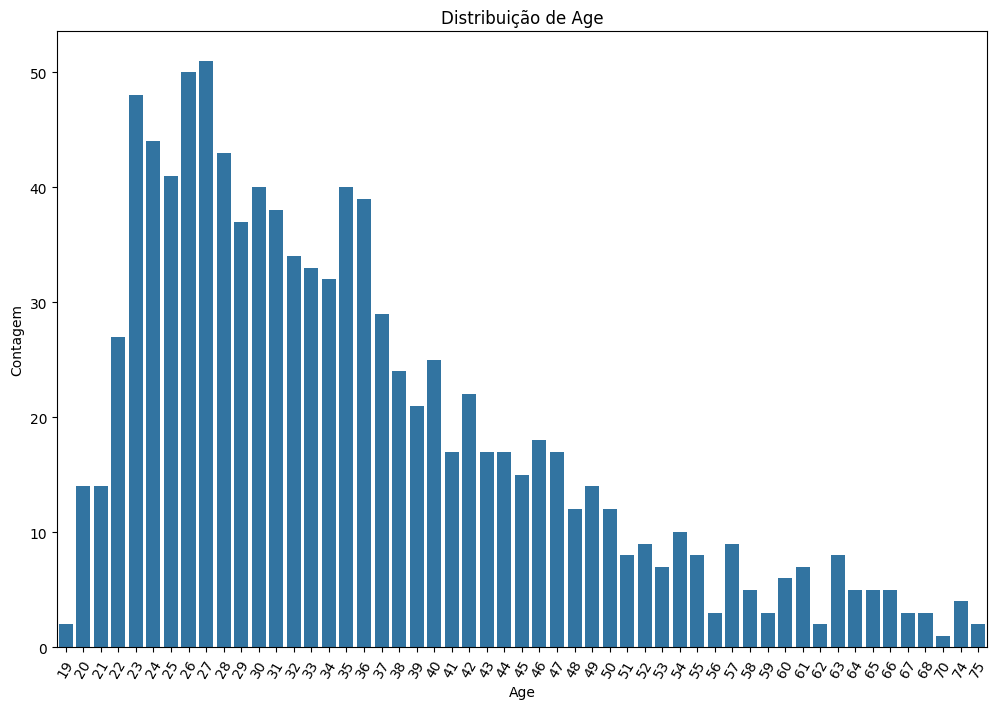

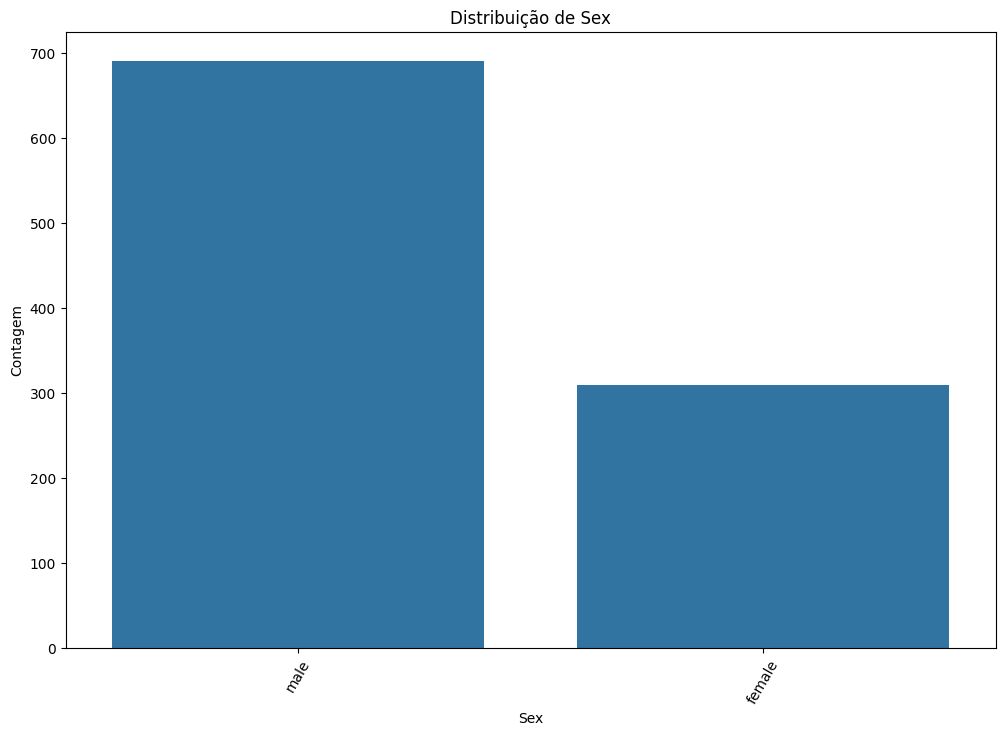

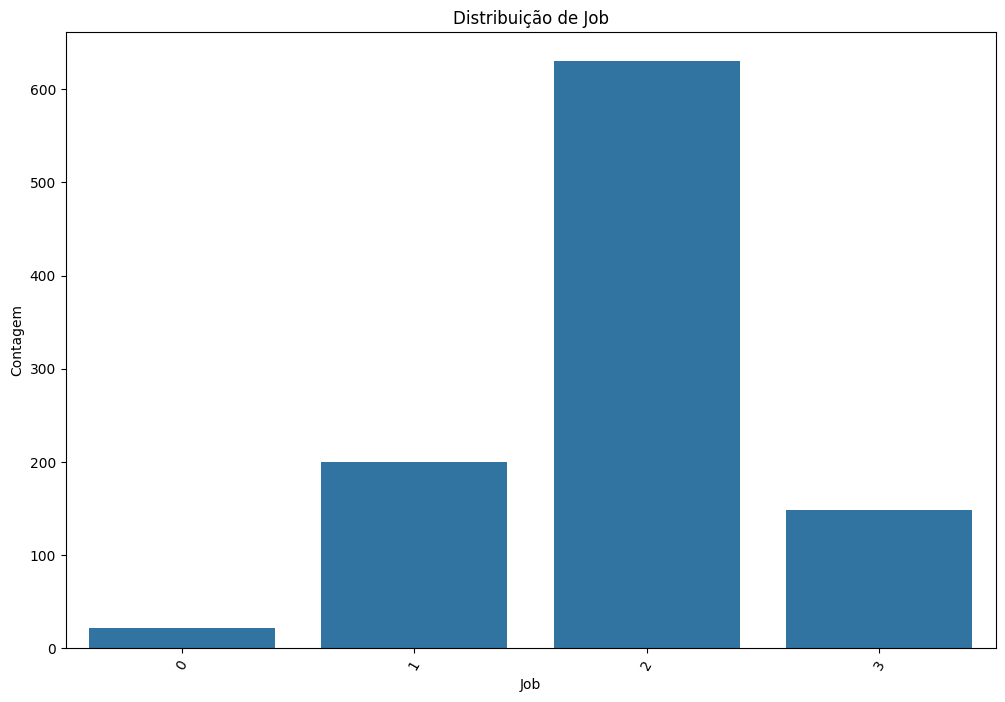

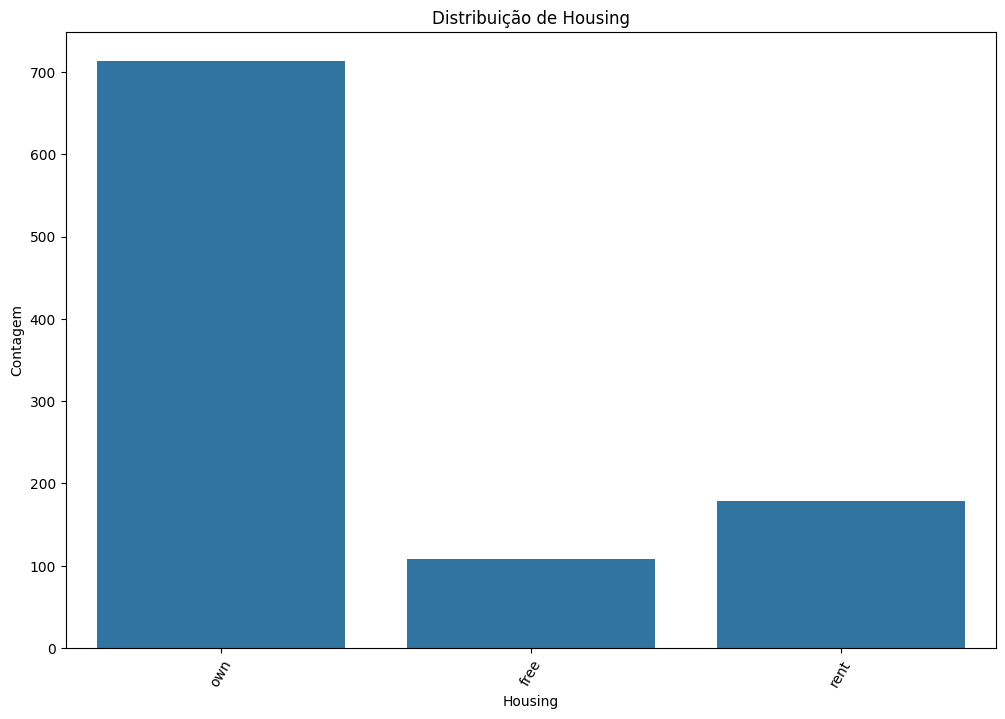

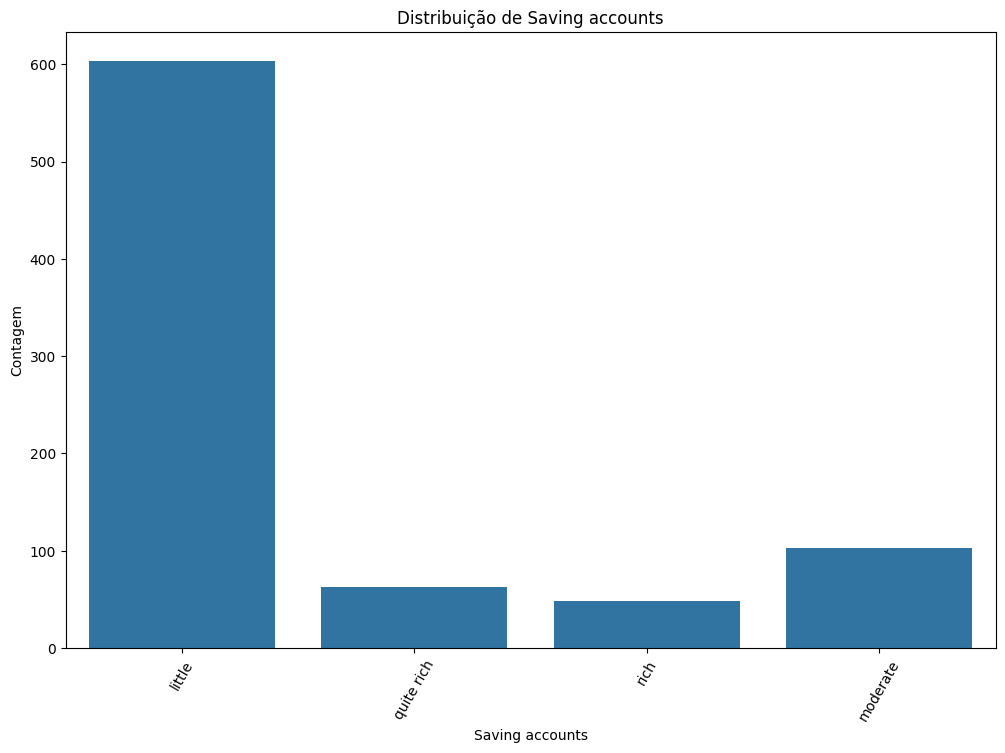

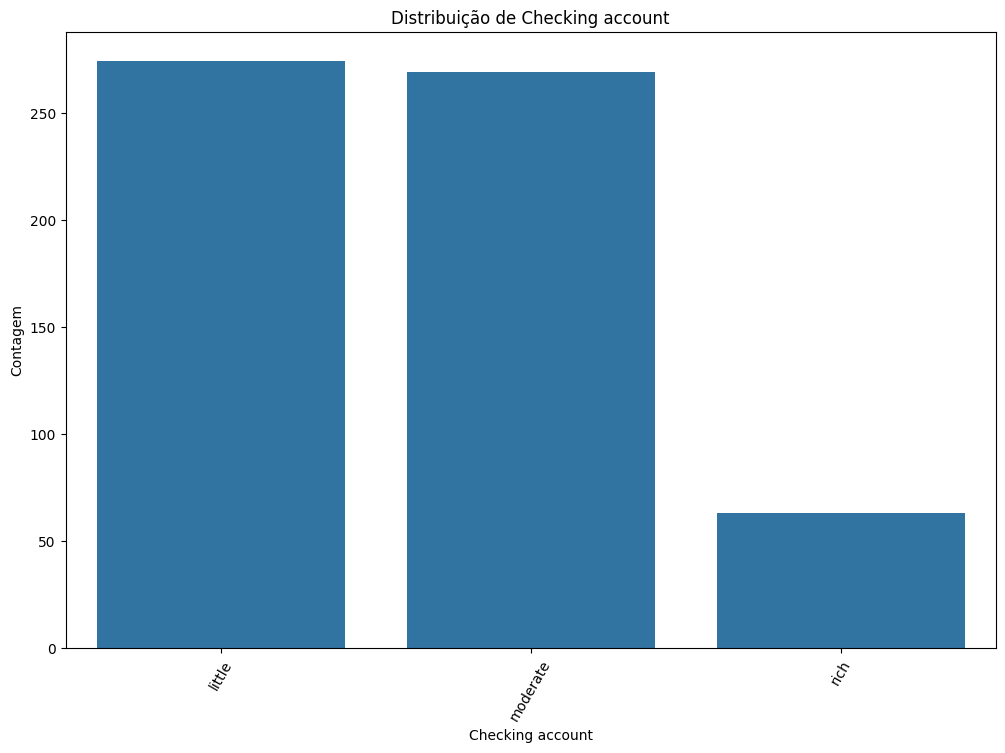

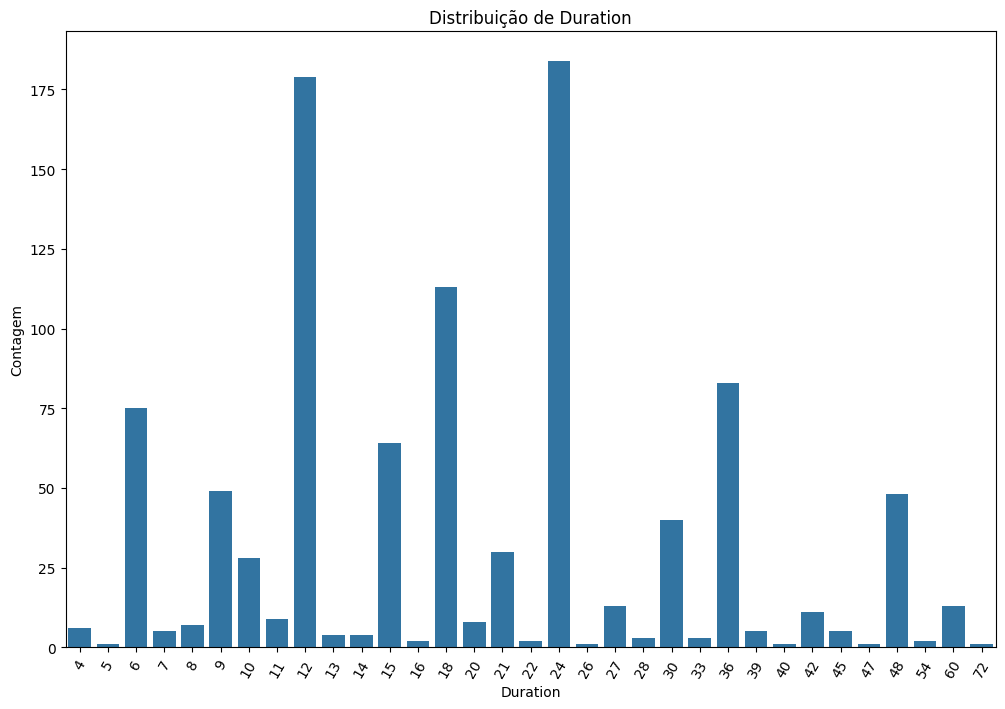

In [9]:
for i in df.drop(columns=['Credit amount']).columns:
    graf_bar(df, i)

Text(0, 0.5, 'Contagem')

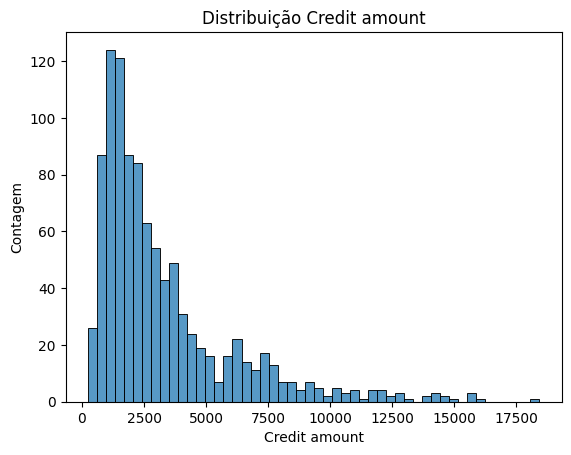

In [19]:
plt.title('Distribuição Credit amount')
sns.histplot(data=df, x='Credit amount', bins=50)
plt.ylabel('Contagem')

* Bivariada

In [11]:
# Correlação entre as variáveis numéricas:

df[list_num].corr()

,Age,Job,Credit amount,Duration
Age,1.000000,0.015673,0.032716,-0.036136
Job,0.015673,1.000000,0.285385,0.210910
Credit amount,0.032716,0.285385,1.000000,0.624984
Duration,-0.036136,0.210910,0.624984,1.000000


Não encontramos nenhuma variável com uma correlação alta.

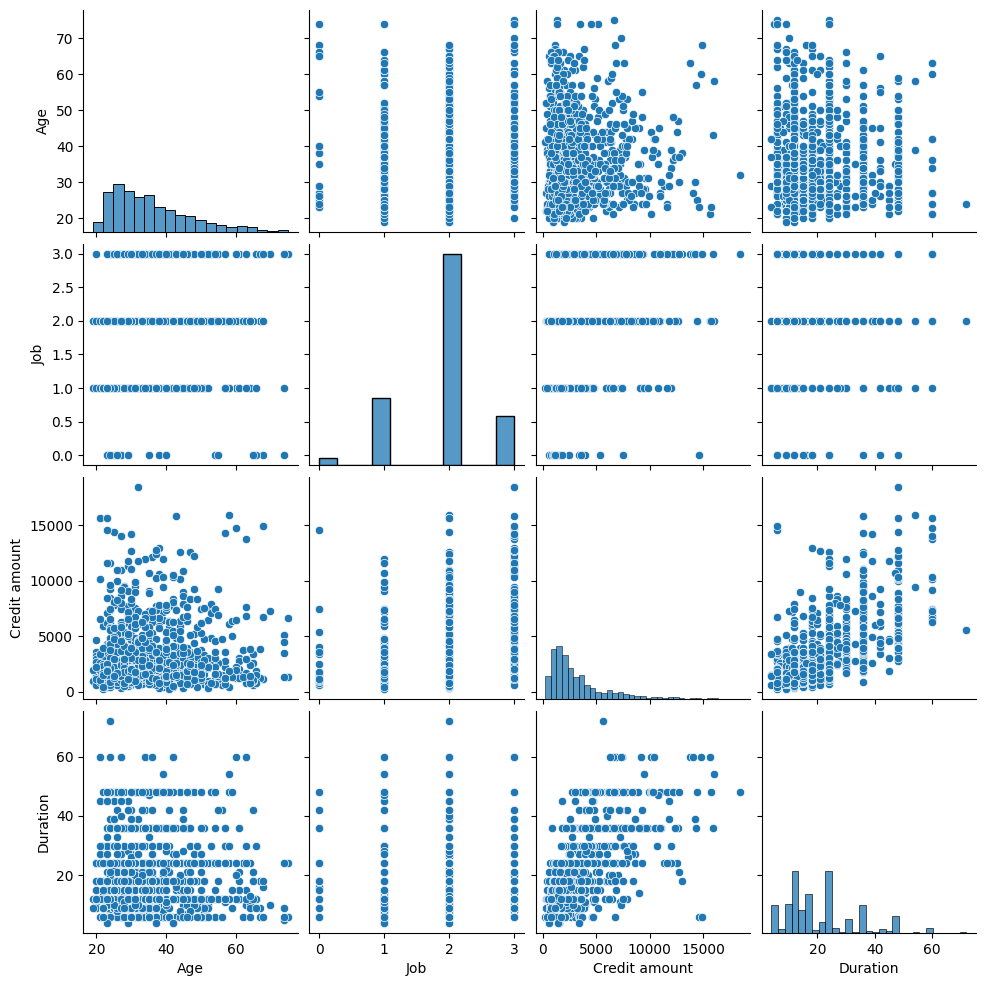

In [11]:
# Relação entre as variáveis numéricas:

sns.pairplot(data=df[list_num])

Das variáveis acima, notamos uma maior correlação entre Credit amount e Duration, vamos explorar esta relação:

In [28]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration'],
      dtype='object')

<Axes: xlabel='Credit amount', ylabel='Duration'>

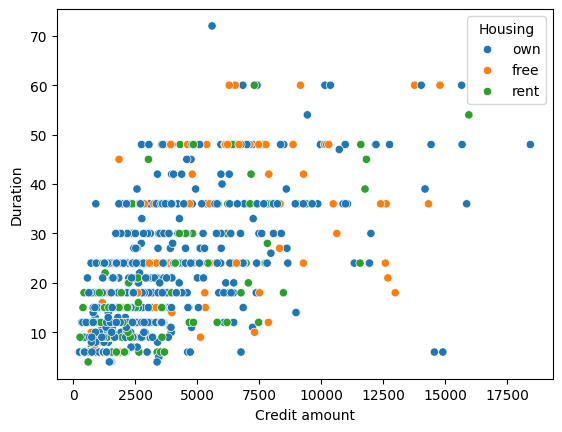

In [26]:
sns.scatterplot(x='Credit amount', y='Duration', data=df, hue='Housing')

Text(0, 0.5, 'Contagem')

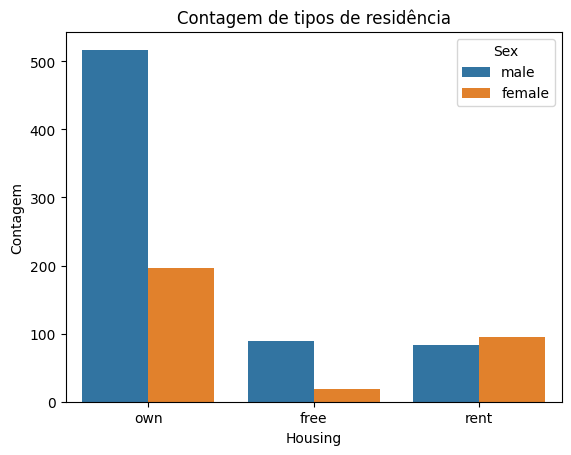

In [20]:
plt.title('Contagem de tipos de residência')
sns.countplot(x='Housing', hue='Sex', data=df)
plt.ylabel('Contagem')

Nota-se uma discrepancia na proporção de clientes de diferentes sexos para os tipos de residência.

<Axes: xlabel='Housing', ylabel='count'>

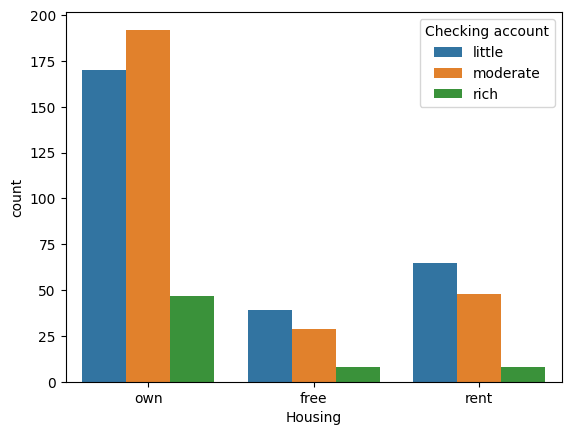

In [18]:
sns.countplot(x='Housing', hue='Checking account', data=df)

### Preprocessamento

In [32]:
# Pipeline de limpeza dos dados:

impt_cat = SimpleImputer(strategy='most_frequent')

encoding = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

scaler = StandardScaler()

prep = ColumnTransformer([
    ('cat', Pipeline(steps=[
        ('impt', impt_cat),
        ('encoding', encoding)
    ]), list_cat),
    ('num', scaler, list_num)
])

pipe_inicial = Pipeline(steps=[
    ('preprocessor', prep),
])

pipe_inicial.fit(df)
df_pipe = pipe_inicial.transform(df)

pipe_inicial

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration'])]))])

In [33]:
# Analizando a explicabilidade por número de componentes na PCA:

pca = PCA().fit(df_pipe)


for i in range(1, 11):
    print(f'n_comp {i}: {pca.explained_variance_ratio_[:i].sum()}')

n_comp 1: 0.31521361393477687
n_comp 2: 0.4978654631055076
n_comp 3: 0.6460674150632587
n_comp 4: 0.7213786893240688
n_comp 5: 0.7902991710828549
n_comp 6: 0.8538478946486623
n_comp 7: 0.9040296894863052
n_comp 8: 0.9435566197953756
n_comp 9: 0.9624997762781704
n_comp 10: 0.9773734570025097


Com 7 componentes principais conseguimos explicar a variância de 90% dos dados.

In [35]:
# Pipeline para limpeza e PCA dos dados:

pca = PCA(n_components=7)

pipe_pca = Pipeline(steps=[
    ('pipe_inicial', pipe_inicial),
    ('pca', pca)
])

pipe_pca.fit(df)
df_final = pipe_pca.transform(df)

pipe_pca

Pipeline(steps=[('pipe_inicial',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('impt',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encoding',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['Sex',
                                                                    'Housing',
                                                                    'Saving '
                                                                    'accounts',
                                                                    'Checking '
                                                                    'account']),
                                                                  ('num',
                                                                   StandardScaler(),
                                                                   ['Age',
                                                                    'Job',
                                                                    'Credit '
                                                                    'amount',
                                                                    'Duration'])]))])),
                ('pca', PCA(n_components=7))])

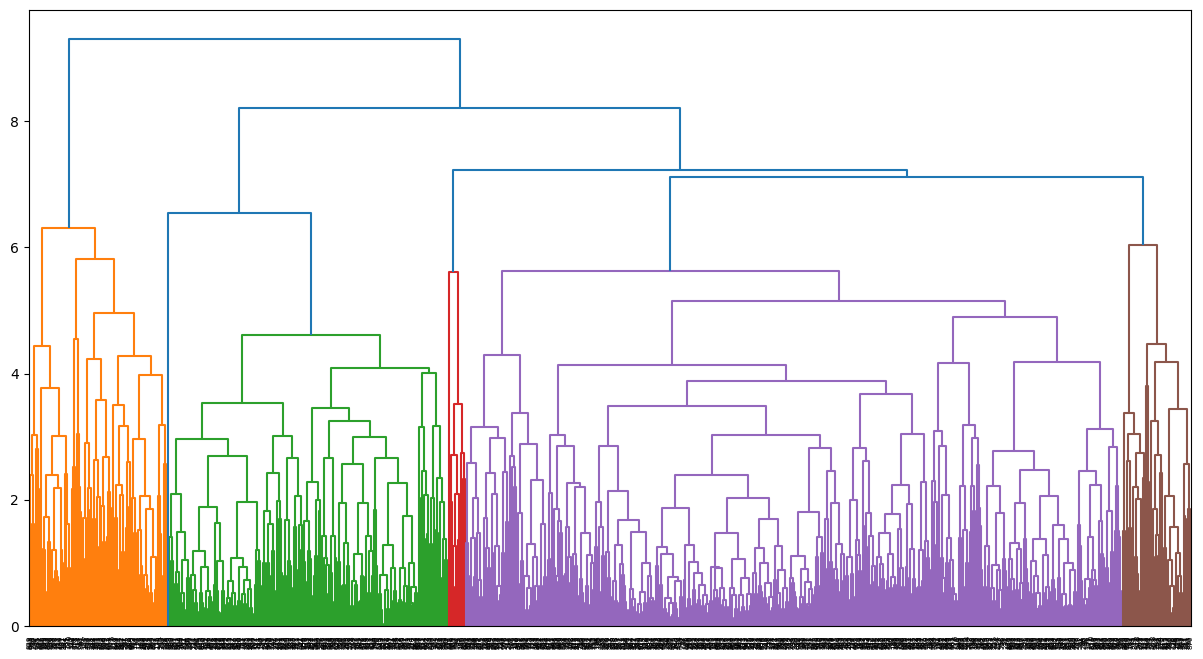

In [37]:
# Visualizando o dendrograma dos dados tratados.

plt.figure(figsize=(15,8))
dend = shc.dendrogram(
    shc.linkage(df_final, method='complete'), color_threshold=6.5)
plt.show()

Com o dendrograma podemos observar a separação dos dados para nos gerar insights sobre os possíveis agrupamentos.

Para decidirmos o número de grupos da clusterização utilizaremos o teste do cotovelo: 

<Axes: xlabel='num_cluster'>

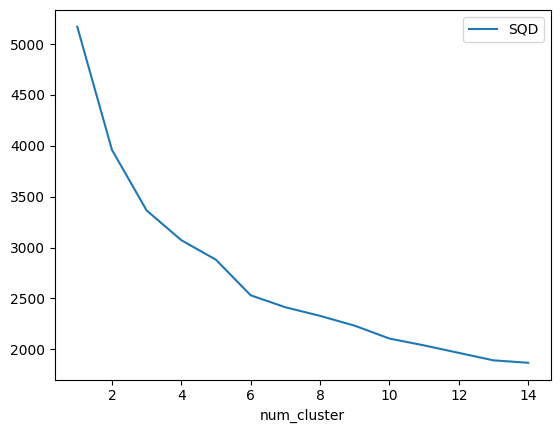

In [38]:
SQD = []

for k in range(1,15):
    km = KMeans(n_clusters=k)
    km.fit(df_final)
    SQD.append(km.inertia_)

df_clus = pd.DataFrame({'num_cluster':list(range(1, len(SQD)+1)), 'SQD':SQD})
df_clus.plot(x = 'num_cluster', y= 'SQD')

O número de clusters mais adequado é entre 3 e 5. Vamos escolher uma clusterização com 4 clusters para dar continuidade no projeto.

### Clusterização e Avaliação de Grupos

In [39]:
# Construindo uma pipeline com limpeza, PCA e clusterização dos dados:

km = KMeans(n_clusters=4)

pipe_kmeans = Pipeline(steps=[
    ('pipe_pca', pipe_pca),
    ('kmeans', km)
])

pipe_kmeans.fit(df)

pipe_kmeans

Pipeline(steps=[('pipe_pca',
                 Pipeline(steps=[('pipe_inicial',
                                  Pipeline(steps=[('preprocessor',
                                                   ColumnTransformer(transformers=[('cat',
                                                                                    Pipeline(steps=[('impt',
                                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                                    ('encoding',
                                                                                                     OneHotEncoder(handle_unknown='ignore',
                                                                                                                   sparse_output=False))]),
                                                                                    ['Sex',
                                                                                     'Housing',
                                                                                     'Saving '
                                                                                     'accounts',
                                                                                     'Checking '
                                                                                     'account']),
                                                                                   ('num',
                                                                                    StandardScaler(),
                                                                                    ['Age',
                                                                                     'Job',
                                                                                     'Credit '
                                                                                     'amount',
                                                                                     'Duration'])]))])),
                                 ('pca', PCA(n_components=7))])),
                ('kmeans', KMeans(n_clusters=4))])

In [40]:
# Criando uma coluna com a label prevista pela clusterização:

df['cluster'] = pipe_kmeans['kmeans'].labels_
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,cluster
0,67,male,2,own,NaN,little,1169,6,0
1,22,female,2,own,little,moderate,5951,48,2
2,49,male,1,own,little,NaN,2096,12,0
3,45,male,2,free,little,little,7882,42,2
4,53,male,2,free,little,little,4870,24,0


In [41]:
# Distribuição dos grupos:

df['cluster'].value_counts()

cluster
3    388
1    223
0    204
2    185
Name: count, dtype: int64

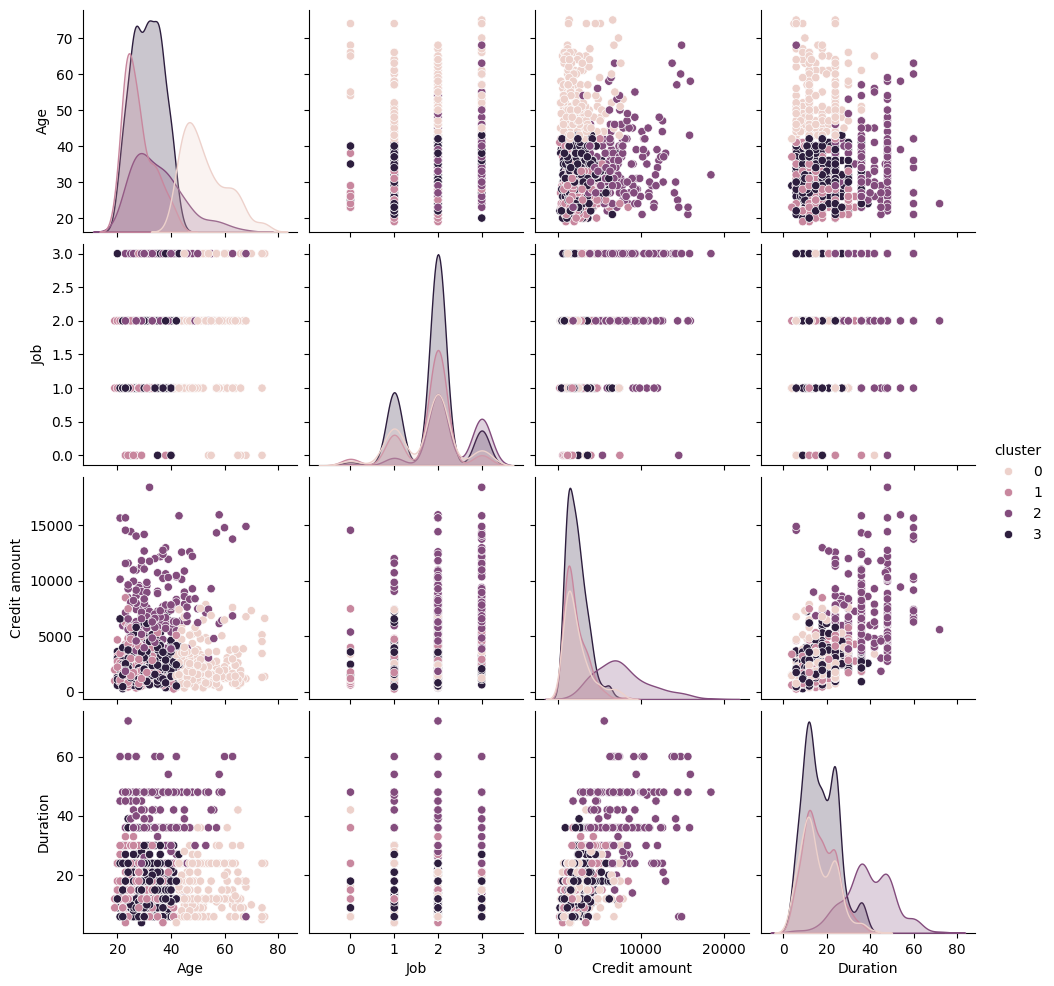

In [42]:
# Visualizando a relação das variáveis numéricas discriminando os grupos:

df_num = df.select_dtypes('number')

sns.pairplot(data=df_num, hue='cluster')

Podemos identificar uma certa separação considerável entre os dados. A maior parte da confusão para os gráficos relacionados a Credit amount esta relacionado a baixos valores.

In [43]:
# Criando uma tabela com as componentes principais e os grupos:

df_trans = pipe_kmeans.transform(df)

cols = [f'pc{i}' for i in range(df_trans.shape[1])]
df_trans_pc = pd.DataFrame(df_trans, columns=cols)

df_trans_pc['cluster'] = pipe_kmeans['kmeans'].labels_

df_trans_pc

,pc0,pc1,pc2,pc3,cluster
0,1.695948,3.897705,4.627524,3.349781,0
1,4.295584,3.179656,2.129217,3.435845,2
2,1.374512,2.744349,3.865885,2.169207,0
3,3.160592,3.758933,1.404962,3.322256,2
4,1.506070,3.077902,2.483877,2.489341,0
...,...,...,...,...,...
995,2.536994,1.479846,3.909689,2.067550,1
996,2.596749,2.923481,2.086450,2.318185,2
997,1.576832,1.930392,3.446191,1.088341,3
998,3.615078,2.918212,2.519996,2.593266,2


In [48]:
# Definindo uma função para analisar a relação entre as pcs:

def pc_analise(pcx, pcy):    
    fig, axs = plt.subplots(2, 1, figsize=(6,6))

    sns.scatterplot(data=df_trans_pc, x=pcx, y=pcy, hue='cluster', ax=axs[0], palette='viridis')
    sns.kdeplot(data=df_trans_pc, x=pcx, y=pcy, hue='cluster',ax = axs[1], fill=True, alpha=.5, palette='viridis')

    plt.show()

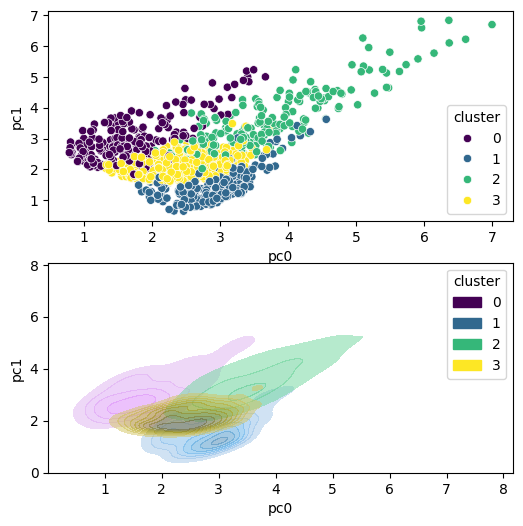

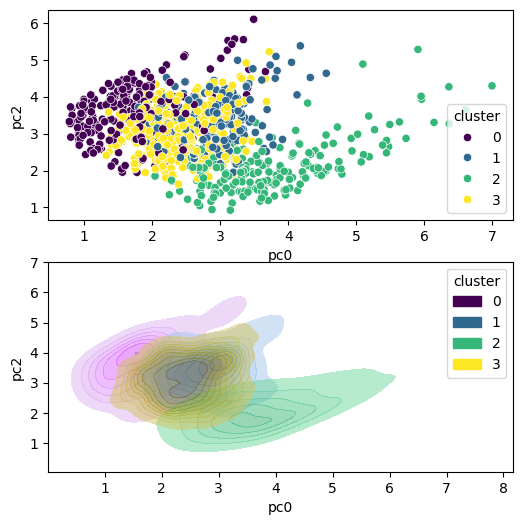

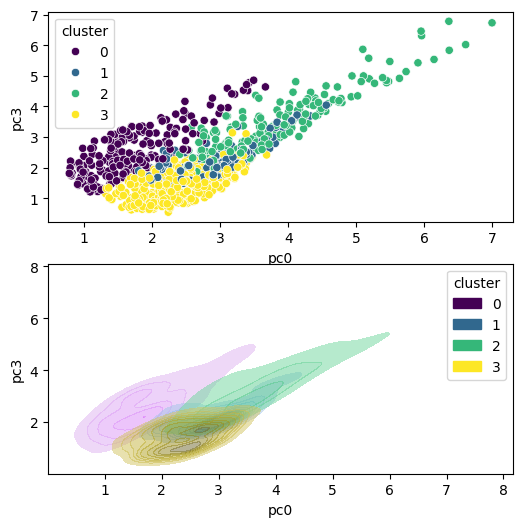

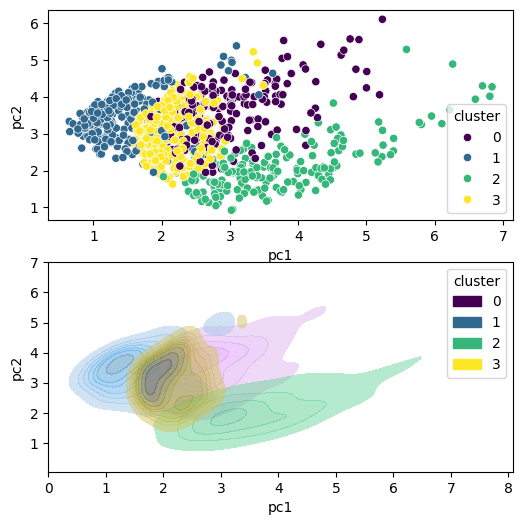

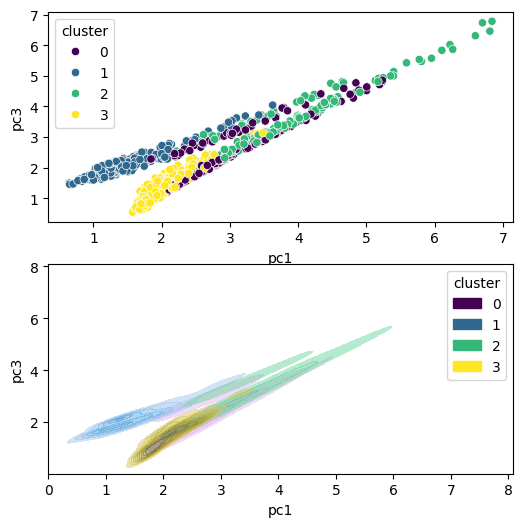

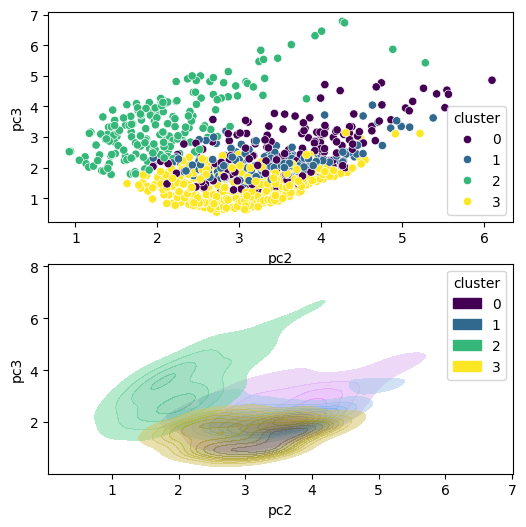

In [49]:
pcs = ['pc0', 'pc1', 'pc2', 'pc3']

for i in range(len(pcs)):
    for j in range(i+1, len(pcs)):
        pc_analise(pcs[i], pcs[j])

Podemos notar uma separação dos grupos razoável na relação de algumas das componentes principais. indicando que o modelo consegue agrupar bem os dados. Porém precisamos analisar como as variáveis se distribuem para classificarmos os perfis referentes a cada grupo.

* Analisando os agrupamentos nas variáveis numéricas:

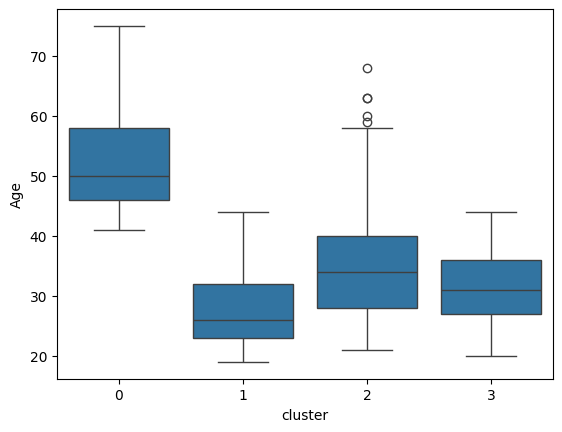

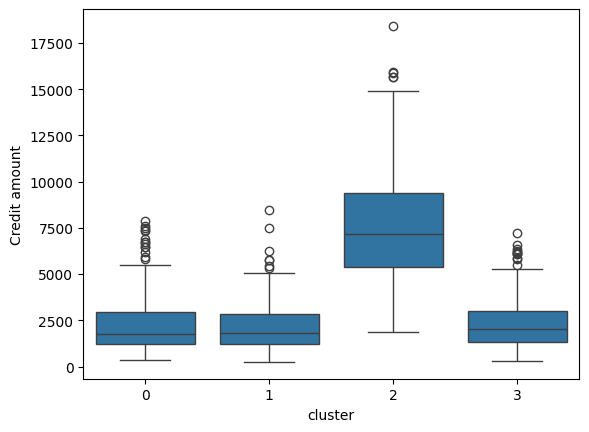

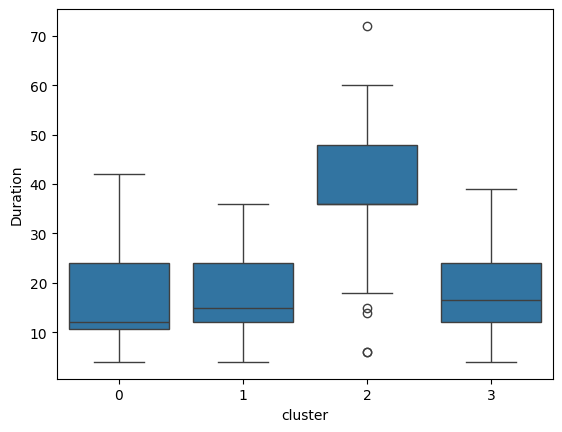

In [50]:
for col in df_num.drop(columns=['cluster', 'Job']).columns:
    sns.boxplot(data=df, x='cluster', y=col)
    plt.show()


In [51]:
g_num = df.groupby('cluster')[df_num.drop(columns=['cluster', 'Job']).columns].mean()
g_num

,Age,Credit amount,Duration
cluster,,,
0,52.500000,2361.200980,15.990196
1,27.919283,2143.547085,16.739910
2,35.210811,7699.621622,39.135135
3,31.175258,2286.422680,17.185567


In [52]:
def media_cluster(var):
    
    sns.pointplot(data=g_num, x=g_num.index, y=g_num[var])

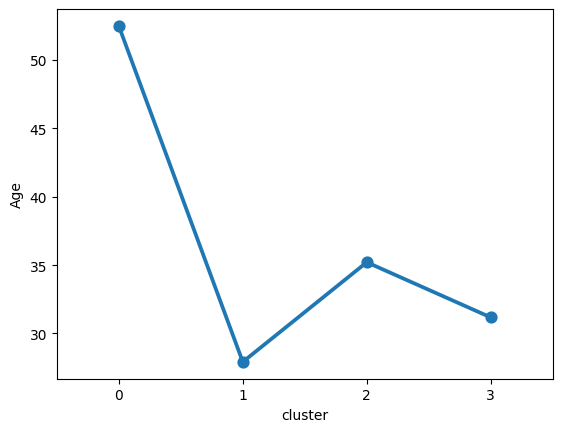

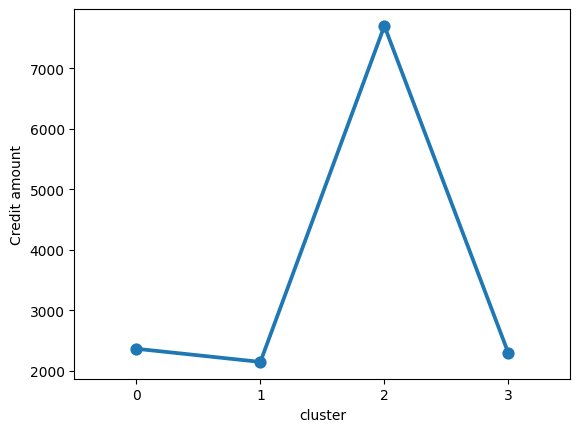

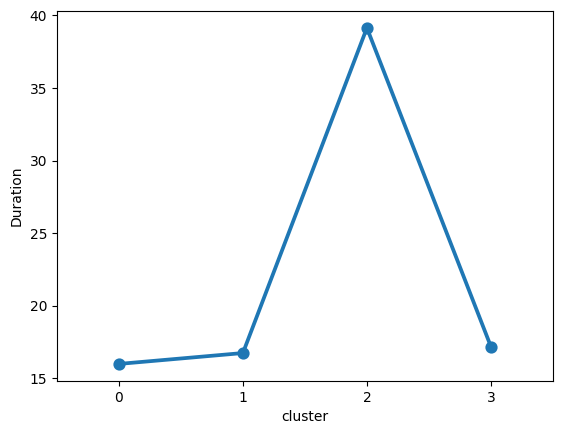

In [53]:
for col in g_num.columns:
    media_cluster(col)
    plt.show()

Categoricas

In [54]:
def groupby_cat(var):
    
    g = df.groupby(['cluster', var]).size().unstack().fillna(0)
    
    return g

* Sex

In [55]:
groupby_cat('Sex')

Sex,female,male
cluster,,
0,48.0,156.0
1,223.0,0.0
2,39.0,146.0
3,0.0,388.0


<Axes: xlabel='cluster'>

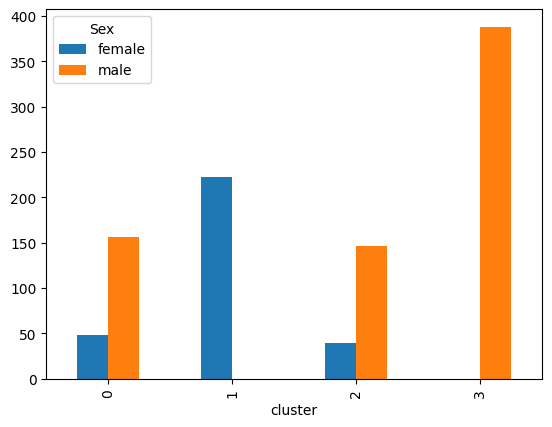

In [56]:
groupby_cat('Sex').plot(kind='bar')

* Housing

In [57]:
groupby_cat('Housing')

Housing,free,own,rent
cluster,,,
0,36,150,18
1,4,137,82
2,43,119,23
3,25,307,56


<Axes: xlabel='cluster'>

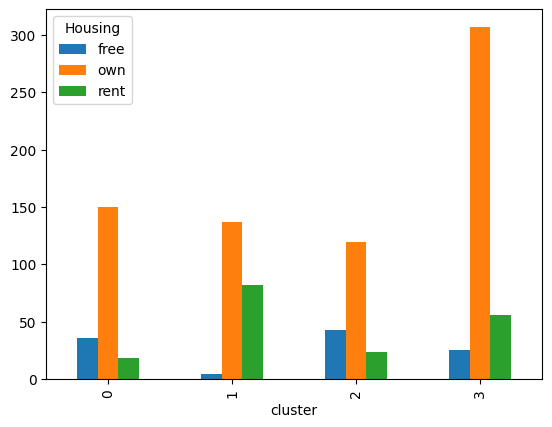

In [58]:
groupby_cat('Housing').plot(kind='bar')

* Saving accounts

In [59]:
groupby_cat('Saving accounts')

Saving accounts,little,moderate,quite rich,rich
cluster,,,,
0,119,13,17,13
1,138,21,12,15
2,110,21,5,4
3,236,48,29,16


<Axes: xlabel='cluster'>

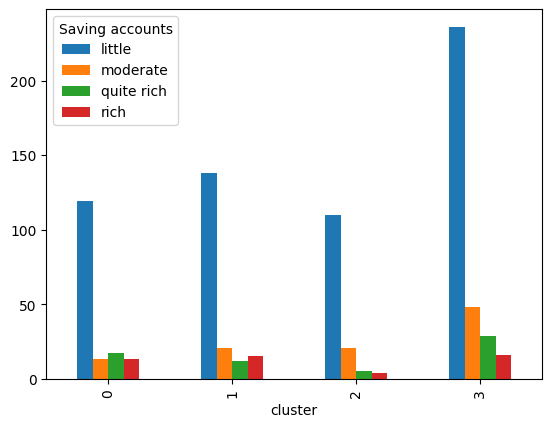

In [60]:
groupby_cat('Saving accounts').plot(kind='bar')

* Checking account

In [61]:
groupby_cat('Checking account')

Checking account,little,moderate,rich
cluster,,,
0,59,31,17
1,68,57,13
2,51,69,5
3,96,112,28


<Axes: xlabel='cluster'>

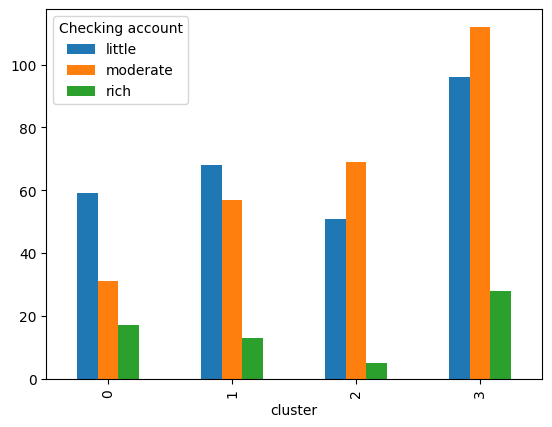

In [62]:
groupby_cat('Checking account').plot(kind='bar')

### Conclusões

 A partir dos agrupamentos e da análise das variáveis e suas relações com estes grupos podemos tirar algumas conclusões sobre as características dos perfis pertencentes a cada grupo:

GRUPO 0:

 - Alta idade
 - Baixo Credit amount
 - Baixa duração de aplicações
 - Perfil com maior quantidade de homens

GRUPO 1:

 - Baixa idade
 - Baixo Credit amount
 - Baixa duração de aplicações
 - Apenas mulheres
 - Porporcionalmente tem mais pessoas vivendo de aluguém em comparação a outros grupos

GRUPO 2:

 - Idade média
 - Alto Credit amount
 - Alta duração de aplicações
 - Perfil com maior quantidade de homens

GRUPO 3:

 - Idade média
 - Baixao Credit amount
 - Baixa duração de apicações
 - Apenas homens
 - Perfil mais populado